In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:

print(os.getcwd())
# 设置设备为GPU（如果可用），否则为CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备：{device}')


In [ ]:
from tools.csv import csv_files

csv_list = csv_files("./res")
all_series = ["Density", "Flow"]

In [ ]:
# 准备数据集
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt


def merge_images(image_paths, grid_size=(2, 2), output_path='merged_image.png'):
    images = [Image.open(img_path) for img_path in image_paths]

    # 图像的宽度和高度（假设所有图片大小相同）
    img_width, img_height = images[0].size

    # 创建画布大小，根据网格尺寸确定最终图片大小
    merged_width = grid_size[1] * img_width
    merged_height = grid_size[0] * img_height

    # 创建一个新画布
    merged_image = Image.new('RGB', (merged_width, merged_height))

    # 在画布上按网格位置粘贴图像
    for index, img in enumerate(images):
        row = index // grid_size[1]
        col = index % grid_size[1]
        merged_image.paste(img, (col * img_width, row * img_height))

    # 保存合并后的图像
    merged_image.save(output_path)
    print(f"Merged image saved as {output_path}")

    # 使用 matplotlib 显示合并后的图片
    plt.imshow(merged_image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()



In [ ]:
for csv_path in csv_list:
    for series_name in all_series:
        df = pd.read_csv(csv_path)
        # 设置'Frame'为索引
        df.set_index('Frame', inplace=True)
        # 选择要预测的特征
        series = df[series_name].values.astype(float)
        seq_length = 10  # 序列长度设置为10
        X, y = create_sequences(series, seq_length)
        # 检查是否有足够的数据进行训练
        if len(X) == 0:
            print("数据不足以创建指定长度的序列，请减少序列长度或增加数据量。")
        else:
            # 转换为张量并移动到指定设备
            X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)
            y = torch.tensor(y, dtype=torch.float32).to(device)


            # 定义LSTM模型
            class LSTMModel(nn.Module):
                def __init__(self, input_size=1, hidden_size=16, output_size=1):
                    super(LSTMModel, self).__init__()
                    self.hidden_size = hidden_size
                    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
                    self.linear = nn.Linear(hidden_size, output_size)

                def forward(self, x):
                    out, _ = self.lstm(x)
                    out = self.linear(out[:, -1, :])
                    return out


            model = LSTMModel().to(device)  # 将模型移动到指定设备

            # 定义损失函数和优化器
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

            # 训练模型
            epochs = 10000
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                output = model(X)
                loss = criterion(output.squeeze(), y)
                loss.backward()
                optimizer.step()
                if (epoch + 1) % 20 == 0:
                    print(f'{csv_path}-{series_name}-第{epoch + 1}次迭代，损失值: {loss.item():.4f}')

            # 进行预测
            model.eval()
            with torch.no_grad():
                # 使用训练集进行预测，并将结果移动到CPU
                predicted = model(X).squeeze().cpu().numpy()

                # 使用最近的seq_length个数据预测下一个数据点
                recent_sequence = torch.tensor(series[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(
                    device)
                next_prediction = model(recent_sequence).cpu().item()
                print(f'下一个数据点的预测值：{next_prediction:.2f}')

            # 可视化结果并保存图片
            plt.figure()
            plt.plot(range(len(series)), series, label='raw data')
            plt.plot(range(seq_length, len(series)), predicted, label='The training set predicts the data')
            # 将下一个预测值添加到图中
            plt.xlabel('Timeframe')
            plt.ylabel(series_name)
            plt.legend()
            img_dir = "./plots/q1_lstm/" + str('').join(csv_path.split("/")[-2])
            if not os.path.exists(img_dir):
                os.makedirs(str('').join(img_dir), exist_ok=True)

            plt.savefig(
                f'{img_dir}/{csv_path.split("/")[-1]}_{series_name}_prediction_plot.png')  # 保存图片
            plt.close()


['./plots/q1_lstm/32.31.250.103', './plots/q1_lstm/32.31.250.105', './plots/q1_lstm/32.31.250.108', './plots/q1_lstm/32.31.250.107']
Merged image saved as ./plots/q1_lstm/32.31.250.105_merged_image.png


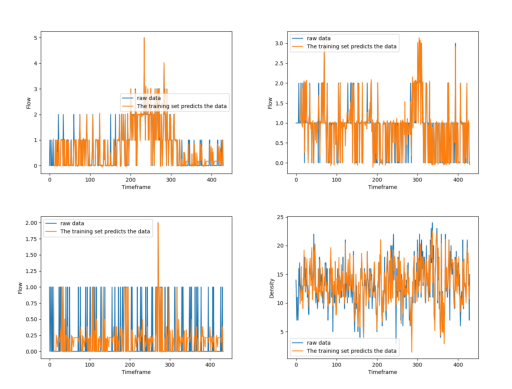

Merged image saved as ./plots/q1_lstm/32.31.250.105_merged_image.png


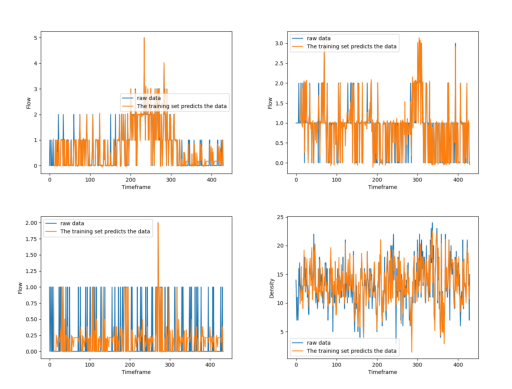

Merged image saved as ./plots/q1_lstm/32.31.250.105_merged_image.png


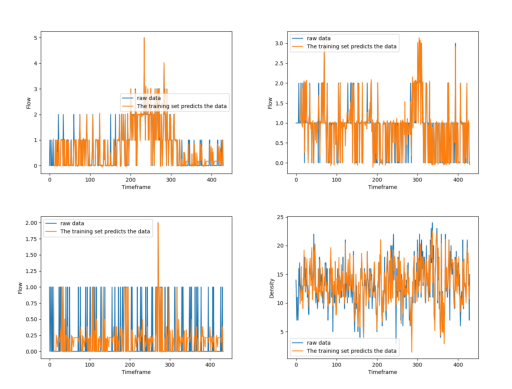

Merged image saved as ./plots/q1_lstm/32.31.250.103_merged_image.png


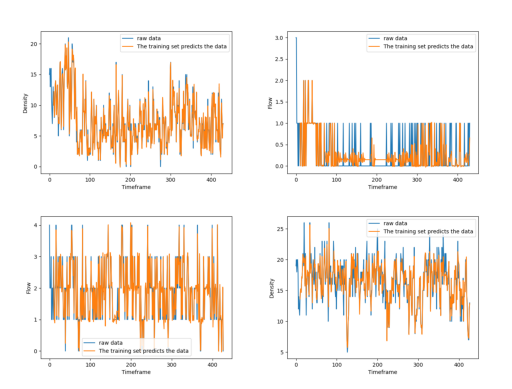

Merged image saved as ./plots/q1_lstm/32.31.250.103_merged_image.png


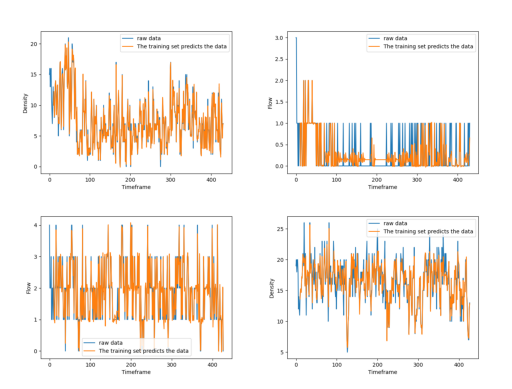

Merged image saved as ./plots/q1_lstm/32.31.250.108_merged_image.png


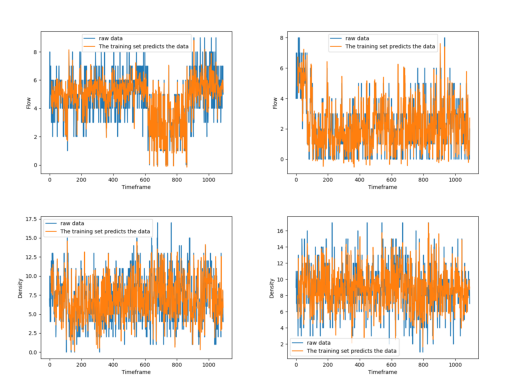

Merged image saved as ./plots/q1_lstm/32.31.250.108_merged_image.png


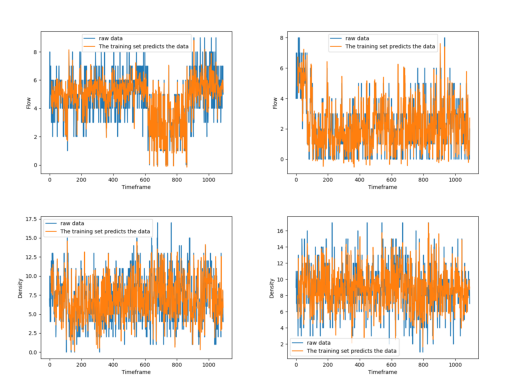

Merged image saved as ./plots/q1_lstm/32.31.250.107_merged_image.png


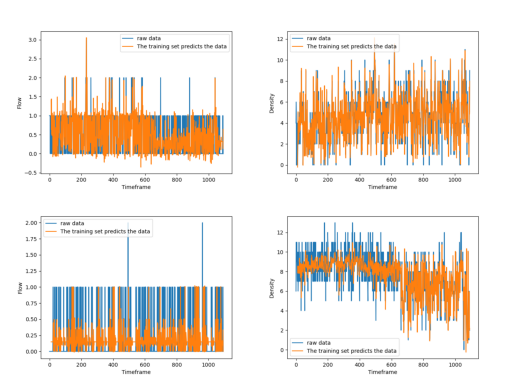

Merged image saved as ./plots/q1_lstm/32.31.250.107_merged_image.png


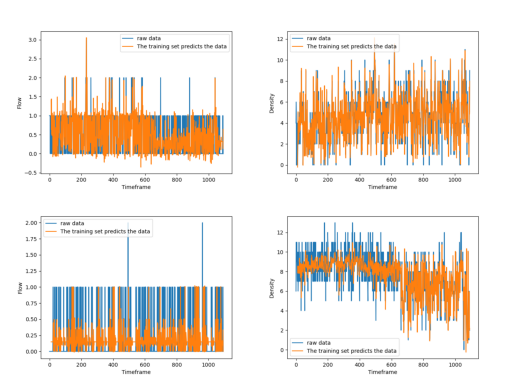

In [103]:
all_dir = []
for csv_path in csv_list:
    all_dir.append("./plots/q1_lstm/" + str("").join(csv_path.split("/")[-2]))
print(list(set(all_dir)))

for folder_path in all_dir:
    image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if
                   img.endswith('.png') or img.endswith('.jpg')]
    merge_images(image_files, grid_size=(2, 2), output_path=f'{folder_path}_merged_image.png')
